c:\Users\paulo.ramos\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
10:59:38 - cmdstanpy - INFO - Chain [1] start processing
10:59:38 - cmdstanpy - INFO - Chain [1] done processing


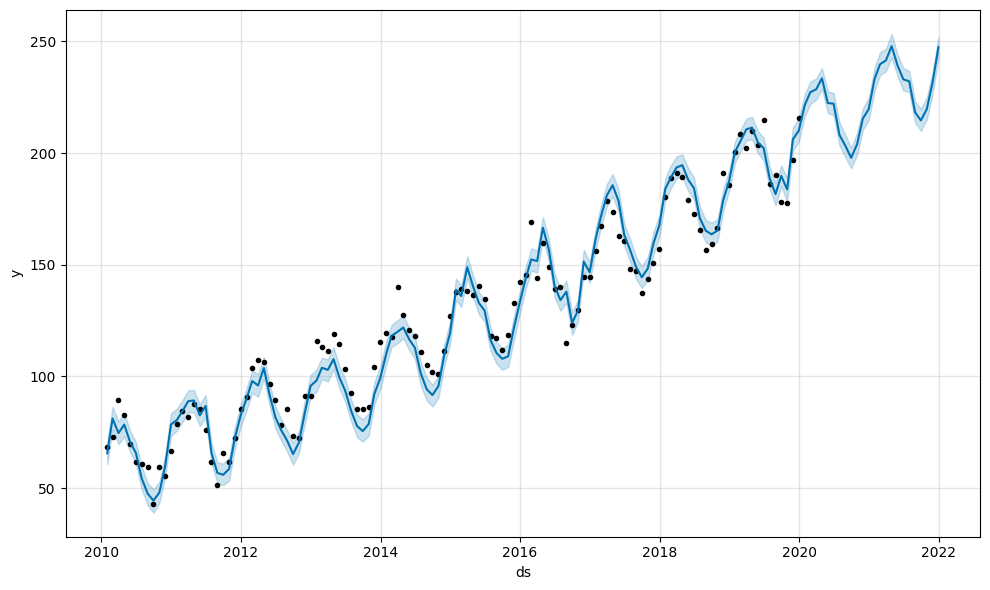

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Configurar la semilla para reproducibilidad
np.random.seed(42)

# Generar fechas mensuales durante 10 años
dates = pd.date_range(start='2010-01-01', periods=120, freq='M')

# Generar una tendencia lineal
trend = np.linspace(50, 200, 120)

# Generar estacionalidad anual
seasonality = 20 * np.sin(2 * np.pi * dates.month / 12)

# Generar ruido aleatorio
noise = np.random.normal(scale=5, size=120)

# Crear regresores sintéticos:
# 1. Regresor 1: Factor económico cíclico
regressor_1 = np.cos(2 * np.pi * dates.year / 10) + np.random.normal(0, 0.1, 120)

# 2. Regresor 2: Tendencia aleatoria con choques periódicos
regressor_2 = np.cumsum(np.random.normal(0, 0.2, 120))

# 3. Regresor 3: Variable de impacto exógeno (evento ocasional)
regressor_3 = np.random.choice([0, 1], size=120, p=[0.9, 0.1])  # Eventos esporádicos

# Construir la serie temporal base
y = trend + seasonality + noise + 5 * regressor_1 - 3 * regressor_2 + 8 * regressor_3

# Crear DataFrame en formato Prophet
df = pd.DataFrame({'ds': dates, 'y': y, 'regressor_1': regressor_1, 'regressor_2': regressor_2, 'regressor_3': regressor_3})

# Crear y entrenar modelo Prophet con los regresores
model = Prophet(yearly_seasonality=True)
model.add_regressor('regressor_1')
model.add_regressor('regressor_2')
model.add_regressor('regressor_3')
model.fit(df)

# Generar pronóstico para 24 meses futuros
future = model.make_future_dataframe(periods=24, freq='M')

# Crear valores futuros para los regresores
future['regressor_1'] = np.cos(2 * np.pi * future.ds.dt.year / 10) + np.random.normal(0, 0.1, len(future))
future['regressor_2'] = np.cumsum(np.random.normal(0, 0.2, len(future)))
future['regressor_3'] = np.random.choice([0, 1], size=len(future), p=[0.9, 0.1])

# Realizar la predicción
forecast = model.predict(future)

# Graficar los resultados
fig = model.plot(forecast)
plt.show()


In [2]:
df.head(5)

,ds,y,regressor_1,regressor_2,regressor_3
0,2010-01-31,68.354599,1.079103,-0.158504,0
1,2010-02-28,72.979351,0.909061,-0.181451,0
2,2010-03-31,89.702210,1.140279,-0.080454,1
3,2010-04-30,82.738153,0.859815,0.092697,0
4,2010-05-31,69.606765,1.058686,-0.147362,0


In [3]:
df.tail(10)

,ds,y,regressor_1,regressor_2,regressor_3
110,2019-03-31,202.242318,0.735980,0.166397,0
111,2019-04-30,209.872816,0.830663,0.461468,0
112,2019-05-31,203.646493,0.813574,0.633000,0
113,2019-06-30,214.669434,0.743857,0.601012,1
114,2019-07-31,186.061105,1.023411,0.597209,0
115,2019-08-31,190.317147,0.872409,0.396703,1
116,2019-09-30,177.898441,0.606503,0.393000,0
117,2019-10-31,177.447599,0.827662,0.335269,0
118,2019-11-30,196.968365,0.742838,0.399812,0
119,2019-12-31,215.527868,0.894260,0.234366,1


In [4]:
# Unir los datos originales con los pronósticos
df_forecast = future.copy()
df_forecast['yhat'] = forecast['yhat']  # Pronóstico central
df_forecast['yhat_lower'] = forecast['yhat_lower']  # Límite inferior de confianza
df_forecast['yhat_upper'] = forecast['yhat_upper']  # Límite superior de confianza

# Mostrar los primeros registros del DataFrame actualizado
print(df_forecast.head())


          ds  regressor_1  regressor_2  regressor_3       yhat  yhat_lower  \
0 2010-01-31     0.793256    -0.091872            0  65.640074   60.657867   
1 2010-02-28     0.991088    -0.261841            1  81.204106   76.347403   
2 2010-03-31     0.869553    -0.095774            0  74.685497   69.654611   
3 2010-04-30     1.066967    -0.266991            0  78.478994   73.141889   
4 2010-05-31     1.036660    -0.252677            0  70.674258   66.128847   

   yhat_upper  
0   70.730530  
1   86.392421  
2   79.957252  
3   83.500683  
4   75.633743  


In [5]:
df_forecast.tail()

,ds,regressor_1,regressor_2,regressor_3,yhat,yhat_lower,yhat_upper
139,2021-08-31,0.767488,-0.579523,0,218.193599,213.507228,223.181086
140,2021-09-30,0.872295,-0.575836,0,214.611674,209.947641,219.779449
141,2021-10-31,1.036086,-0.506320,0,219.646562,215.018630,224.961767
142,2021-11-30,0.827204,-0.614272,0,231.446373,226.252990,235.995048
143,2021-12-31,0.833839,-0.769933,1,247.347220,242.383952,252.114385


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Filtrar solo los datos históricos donde tenemos valores reales
df_eval = df.merge(df_forecast[['ds', 'yhat']], on='ds', how='inner')

# Calcular métricas de evaluación
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
mse = mean_squared_error(df_eval['y'], df_eval['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((df_eval['y'] - df_eval['yhat']) / df_eval['y'])) * 100
r2 = r2_score(df_eval['y'], df_eval['yhat'])

# Mostrar resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MAE: 6.70
MSE: 66.10
RMSE: 8.13
MAPE: 6.01%
R²: 0.9646


In [7]:
# Extraer coeficientes de los regresores en el modelo
model_params = model.params
print(model_params['beta'])  # Coeficientes de los regresores


[[ 0.0960091   0.00954973 -0.05916     0.0134944   0.00784009  0.0266061
  -0.119297   -0.017287   -0.00439279  0.0234161   0.0156857   0.00571234
   0.0162694  -0.0194663  -0.116582   -0.0354735   0.0128231  -0.0118564
  -0.0522822  -0.0301789   0.014119   -0.013485    0.0377175 ]]


In [8]:
import pandas as pd

# Obtener solo las columnas de los regresores (las primeras columnas de beta)
num_regressors = 3  # Número de regresores agregados
regressor_names = ['regressor_1', 'regressor_2', 'regressor_3']

# Crear un DataFrame con los coeficientes de los regresores
coefficients_df = pd.DataFrame(model_params['beta'][:, :num_regressors], columns=regressor_names)

# Mostrar los coeficientes de los regresores
coefficients_df


,regressor_1,regressor_2,regressor_3
0,0.096009,0.00955,-0.05916


In [9]:
print(model.seasonalities)


OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])


In [10]:
# Puntos de Cambio en la Tendencia (Trend Changepoints)
print(model.changepoints)


4    2010-05-31
8    2010-09-30
11   2010-12-31
15   2011-04-30
19   2011-08-31
23   2011-12-31
27   2012-04-30
30   2012-07-31
34   2012-11-30
38   2013-03-31
42   2013-07-31
46   2013-11-30
49   2014-02-28
53   2014-06-30
57   2014-10-31
61   2015-02-28
65   2015-06-30
68   2015-09-30
72   2016-01-31
76   2016-05-31
80   2016-09-30
84   2017-01-31
87   2017-04-30
91   2017-08-31
95   2017-12-31
Name: ds, dtype: datetime64[ns]


In [11]:
# Obtener información de Prophet
print(f"Seasonalities: {model.seasonalities}")  # Componentes estacionales
print(f"Changepoints: {len(model.changepoints)} puntos de cambio en tendencia")  # Cambios en tendencia

# Ver estructura de los coeficientes
print(f"Tamaño de beta: {model_params['beta'].shape}")  # Dimensiones de los coeficientes


Seasonalities: OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
Changepoints: 25 puntos de cambio en tendencia
Tamaño de beta: (1, 23)


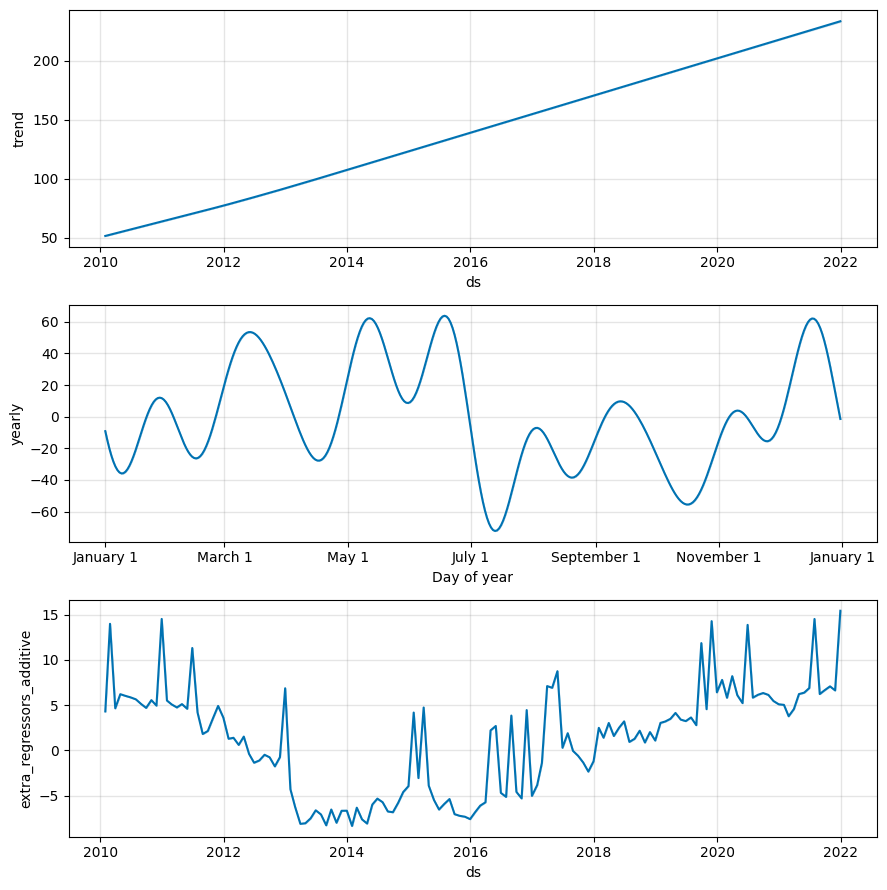

In [12]:
fig = model.plot_components(forecast)
plt.show()
